In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.metrics import accuracy, recall, precision, fbeta

/home/iab-j/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, class_num, lamb=0.2, alpha=None, gamma=2, size_average=True):
        super(FocalLoss, self).__init__()
        if alpha is None:
            self.alpha = Variable(torch.ones(class_num, 1))
        else:
            if isinstance(alpha, Variable):
                self.alpha = alpha
            else:
                self.alpha = Variable(alpha)
        self.lamb=lamb
        self.gamma = gamma
        self.class_num = class_num
        self.size_average = size_average
        print(self.lamb, self.gamma, self.class_num, self.size_average)

    def forward(self, inputs, targets):
        N = inputs.size(0)
        C = inputs.size(1)
        
        ce_loss=F.cross_entropy(inputs, targets)
        
        P = F.softmax(inputs)

        class_mask = inputs.data.new(N, C).fill_(0)
        class_mask = Variable(class_mask)
        ids = targets.view(-1, 1)

        class_mask.scatter_(1, Variable(ids.data), 1.)

        if inputs.is_cuda and not self.alpha.is_cuda:
            self.alpha = self.alpha.cuda()
        alpha = self.alpha[ids.data.view(-1)]

        probs = (P*class_mask).sum(1).view(-1,1)

        log_p = probs.log()


        batch_loss = -alpha*(torch.pow((1-probs), self.gamma))*log_p
        
        batch_loss = batch_loss * class_mask[:,0]
        '''
        #print(batch_loss)
        count=0
        for i in range(len(targets)):
            if(targets[i].data[0]==0):
                count+=1
                batch_loss[i]=0.0
        #print('Hello ',count)
                
        #print(batch_loss)
        '''
        if self.size_average:
            loss = batch_loss.mean()
        else:
            loss = batch_loss.sum()
        
        #final_loss=self.lamb*loss+(1-self.lamb)*ce_loss
        final_loss=loss+ce_loss

        return final_loss
        #return loss

In [3]:
PATH = "/mnt/5C543FBF543F9B2A/Suril_Anannya/Fold_0/"
sz=224
arch=resnext50
bs=28

In [ ]:
learn.summary

In [5]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=2)

In [6]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True), ReLU(), MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False), Sequential(
  (0): Sequential(
    (0): LambdaMap(
      (0): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
          (2): ReLU()
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
          (5): ReLU()
        )
        (1): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps

In [ ]:
learn.summary

In [ ]:
learn.crit

In [ ]:
learn.crit=FocalLoss(2)

In [ ]:
learn.fit(1e-2, 2, metrics=[accuracy, recall, precision])

In [7]:
learn.precompute=False

In [ ]:
learn.fit(1e-2, 2)

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot()

In [8]:
learn.save('model_v1')

In [ ]:
learn.unfreeze()
lr=np.array([1e-5,1e-4,1e-3])

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2, metrics=[accuracy, recall, precision],best_save_name='model_v2')

In [14]:
learn.load('model_v2')

In [ ]:
learn.load('late_realisation_model_v1')
lr=np.array([1e-6,1e-5,1e-4])

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2, best_save_name='late_realisation_model_v2')

In [ ]:
learn.load('model_v2')
lr=np.array([1e-6,1e-5,1e-5])

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2, best_save_name='model_v3')

In [ ]:
learn.load('late_realisation_model_v2')

In [15]:
log_preds,y = learn.TTA()

In [16]:
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs,y)

0.65

In [17]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[27  0  0  3]
 [ 2  0  0  1]
 [ 8  0  2  9]
 [ 4  0  1 23]]


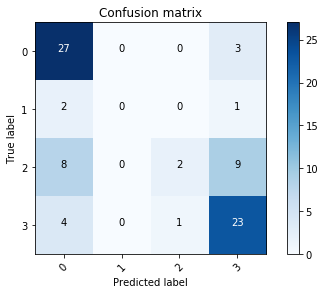

In [18]:
plot_confusion_matrix(cm, data.classes)

In [28]:
print(preds)
print(data.val_y)

[0 0 0 3 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 3 3 3 3 0 0 0 0 3 2 2 3 0 3 3 3 0 3
 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 2 3 3 0 0 3 3 3 3]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [32]:
from sklearn.metrics import classification_report,accuracy_score,roc_auc_score,matthews_corrcoef
target_names = ['class 0', 'class 1', 'class 2','class 3']

print(classification_report(data.val_y, preds, target_names=target_names))
print(accuracy_score(data.val_y, preds))
# print(roc_auc_score(data.val_y, preds))
print(matthews_corrcoef(data.val_y, preds))

             precision    recall  f1-score   support

    class 0       0.66      0.90      0.76        30
    class 1       0.00      0.00      0.00         3
    class 2       0.67      0.11      0.18        19
    class 3       0.64      0.82      0.72        28

avg / total       0.63      0.65      0.58        80

0.65
0.4841748389444794


/home/iab-j/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most incorrect 0


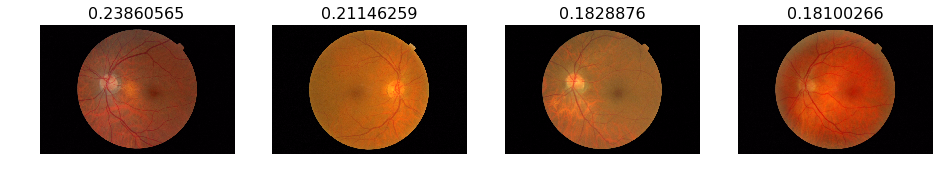

In [20]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect 0")

Most incorrect 1


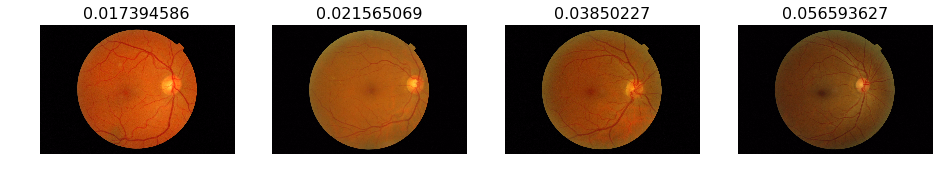

In [21]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect 1")

Most incorrect 2


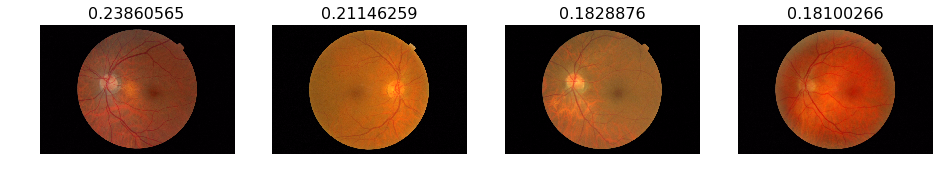

In [22]:
plot_val_with_title(most_by_correct(2, False), "Most incorrect 2")

Most incorrect 3


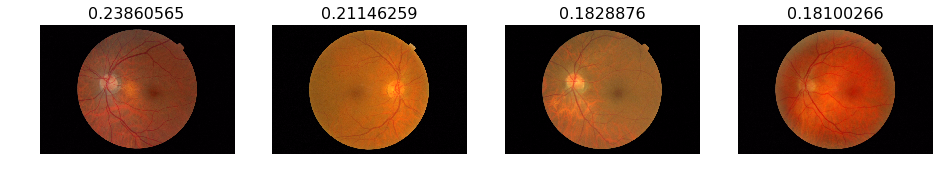

In [23]:
plot_val_with_title(most_by_correct(3, False), "Most incorrect 3")

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score,auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d

fpr, tpr, thresholds = roc_curve(data.val_y,probs)
auc = roc_auc_score(data.val_y, probs)


eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thresholds)(eer)

print (eer,thresh)

In [ ]:
learn.summary

In [ ]:
mod=nn.Sequential(*list(learn.model.children())[:-10])

In [ ]:
mod

In [ ]:
def getFeatureMaps(fn):
    trn_tfms, val_tfms = tfms_from_model(arch, sz)
    im = val_tfms(open_image(fn)) # open_image() returns numpy.ndarray
    features = mod(V(T(im[None])))
    features=features.view(9216).data.cpu().numpy()
    return features

In [ ]:
folders=['train']
X_Train=[]
Y_Train=[]
for folder in folders:
    for categories in os.listdir(PATH+folder):
        for files in os.listdir(PATH+folder+'/'+categories):
            p=PATH+folder+'/'+categories+'/'+files
            X_Train.append(getFeatureMaps(p))
            if(categories=='Real'):
                Y_Train.append(0)
            else:
                Y_Train.append(1)
                
Y_Train=np.asarray(Y_Train)
X_Train=np.asarray(X_Train)

In [ ]:
X_Train.shape

In [ ]:
Y_Train.shape

In [ ]:
np.save(PATH+'X_Train_Feature_maps_X.npy',X_Train)
np.save(PATH+'Y_Train_Feature_maps_X.npy',Y_Train)

In [ ]:
folders=['valid']
X_Test=[]
Y_Test=[]
for folder in folders:
    for categories in os.listdir(PATH+folder):
        for files in os.listdir(PATH+folder+'/'+categories):
            p=PATH+folder+'/'+categories+'/'+files
            X_Test.append(getFeatureMaps(p))
            if(categories=='Real'):
                Y_Test.append(0)
            else:
                Y_Test.append(1)
                
Y_Test=np.asarray(Y_Test)
X_Test=np.asarray(X_Test)

In [ ]:
X_Test.shape

In [ ]:
Y_Test.shape

In [ ]:
np.save(PATH+'X_Test_Feature_maps_X.npy',X_Test)
np.save(PATH+'Y_Test_Feature_maps_X.npy',Y_Test)

In [ ]:
import pickle
import numpy as np
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import itertools
from itertools import cycle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score,auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split

In [ ]:
path='/mnt/5C543FBF543F9B2A/Suril_Anannya/CASIA/'

In [ ]:
X_Train=np.load(PATH+'X_Train_Feature_maps_X.npy')
Y_Train=np.load(PATH+'Y_Train_Feature_maps_X.npy')

X_Test=np.load(PATH+'X_Test_Feature_maps_X.npy')
Y_Test=np.load(PATH+'Y_Test_Feature_maps_X.npy')

print(X_Train.shape,Y_Train.shape)
print(X_Test.shape,Y_Test.shape)

parameters = [{'C': [0.1,1,10,100,1000], 'penalty':['l1','l2'], 'loss':['hinge','squared_hinge'], 'dual':[True,False], 'class_weight':[None,'balanced']}]

#,{'C': [1,10,100], 'gamma': [0.1,0.01,0.001], 'kernel': ['rbf']}]

svr=LinearSVC()
clf = GridSearchCV(estimator=svr, param_grid=parameters, n_jobs=-1, error_score=0.0)

clf.fit(X_Train,Y_Train)

print('Best score for X :', clf.best_score_)
print('On Test_Set:',clf.score(X_Test,Y_Test))
print('Best_model:',clf.best_params_)

with open(PATH+'SVM_Alex_X.pkl', 'wb') as f:
    pickle.dump(clf, f)
''' 
with open(path+'SVM_Alex.pkl', 'rb') as f:
    clf=pickle.load(f)
'''
    
#plot_Conf(Y_Test,preds,'SMAD_Upper_Patches')

#X_Test, X_val, Y_Test, Y_val = train_test_split(X_Test, Y_Test, test_size=0.1, stratify=Y_Test)

print(X_Test.shape,Y_Test.shape)
#print(X_val.shape,Y_val.shape)

cclf = CalibratedClassifierCV(base_estimator=clf, cv='prefit', method='sigmoid')
cclf.fit(X_Train, Y_Train)
preds_1=cclf.predict(X_Test)
probs_1=cclf.predict_proba(X_Test)
print(cclf.score(X_Test,Y_Test))

In [ ]:
print(probs_1)

In [ ]:
print(Y_Test)
Y_Test.shape

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_Test,probs_1[:,1])
auc = roc_auc_score(Y_Test,probs_1[:,1])


eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thresholds)(eer)

print (eer,thresh)

In [ ]:
cm_1 = confusion_matrix(Y_Test,preds_1)

In [ ]:
plot_confusion_matrix(cm_1, data.classes)

In [ ]:
np.save(PATH+'SVM_probs_X.npy',probs_1)